# Regression Week 4: Ridge Regression (gradient descent)

In this notebook, you will implement ridge regression via gradient descent. You will:
* Write a Numpy function to compute the derivative of the regression weights with respect to a single feature
* Write gradient descent function to compute the regression weights given an initial weight vector, step size, tolerance, and L2 penalty

# Imports

In [1]:
# Standard libs
import pandas as pd
import numpy as np

# Math
from math import sqrt

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline

# Load in house sales data

Dataset is from house sales in King County, the region where the city of Seattle, WA is located.

In [2]:
sales_dtype={'bathrooms':float, 'waterfront':int, 'sqft_above':int,
             'sqft_living15':float, 'grade':int, 'yr_renovated':int,
             'price':float, 'bedrooms':float, 'zipcode':str, 'long':float,
             'sqft_lot15':float, 'sqft_living':float, 'floors':str, 'condition':int,
             'lat':float, 'date':str, 'sqft_basement':int, 'yr_built':int, 'id':str,
             'sqft_lot':int, 'view':int}

In [3]:
sales = pd.read_csv("./data/kc_house_data.csv", dtype=sales_dtype)
sales.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340.0,5650.0
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690.0,7639.0
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720.0,8062.0
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360.0,5000.0
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800.0,7503.0
5,7237550310,20140512T000000,1225000.0,4.0,4.50,5420.0,101930,1,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760.0,101930.0
6,1321400060,20140627T000000,257500.0,3.0,2.25,1715.0,6819,2,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238.0,6819.0
7,2008000270,20150115T000000,291850.0,3.0,1.50,1060.0,9711,1,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650.0,9711.0
8,2414600126,20150415T000000,229500.0,3.0,1.00,1780.0,7470,1,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780.0,8113.0
9,3793500160,20150312T000000,323000.0,3.0,2.50,1890.0,6560,2,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390.0,7570.0


# Import useful functions from previous notebook

Copy and paste `get_numpy_data()` from the second notebook of Week 2.

In [4]:
def get_numpy_data(data_frame, features, output):
    nb_observations = data_frame.shape[0]
    feature_matrix = np.concatenate((np.ones((nb_observations,1)),data_frame.as_matrix(columns=features)),axis=1)
    output_array = data_frame.as_matrix(columns=output)
    return(feature_matrix, output_array)

Also, copy and paste the `predict_output()` function to compute the predictions for an entire matrix of features given the matrix and the weights:

In [5]:
def predict_output(feature_matrix, weights):   
    predictions = np.dot(feature_matrix, weights)
    return(predictions)

# Computing the Derivative

We are now going to move to computing the derivative of the regression cost function. Recall that the cost function is the sum over the data points of the squared difference between an observed output and a predicted output, plus the L2 penalty term.
```
Cost(w)
= SUM[ (prediction - output)^2 ]
+ l2_penalty*(w[0]^2 + w[1]^2 + ... + w[k]^2).
```

Since the derivative of a sum is the sum of the derivatives, we can take the derivative of the first part (the RSS) as we did in the notebook for the unregularized case in Week 2 and add the derivative of the regularization part.  As we saw, the derivative of the RSS with respect to `w[i]` can be written as: 
```
2*SUM[ error*[feature_i] ].
```
The derivative of the regularization term with respect to `w[i]` is:
```
2*l2_penalty*w[i].
```
Summing both, we get
```
2*SUM[ error*[feature_i] ] + 2*l2_penalty*w[i].
```
That is, the derivative for the weight for feature i is the sum (over data points) of 2 times the product of the error and the feature itself, plus `2*l2_penalty*w[i]`. 

**We will not regularize the constant.**  Thus, in the case of the constant, the derivative is just twice the sum of the errors (without the `2*l2_penalty*w[0]` term).

Recall that twice the sum of the product of two vectors is just twice the dot product of the two vectors. Therefore the derivative for the weight for feature_i is just two times the dot product between the values of feature_i and the current errors, plus `2*l2_penalty*w[i]`.

With this in mind complete the following derivative function which computes the derivative of the weight given the value of the feature (over all data points) and the errors (over all data points).  To decide when to we are dealing with the constant (so we don't regularize it) we added the extra parameter to the call `feature_is_constant` which you should set to `True` when computing the derivative of the constant and `False` otherwise.

## Computing the Derivative (using Matrix representation)

Instead of the above, let's use the Matrix representation:


$\bigtriangledown RSS = 2*H^T*(y - Hw) + 2*\lambda*w$

with $(y - Hw)$ being the errors, and $\lambda$ the l2 penalty

**We are not regularising the constant, i.e. w0. So for w0 2\*$\lambda$\*w must be 0**

One trick is to define wi as identity matrix of size len(w), then setting wi[0,0]=0 and to use vector np.dot(wi,w) for calculation of the regularisation term. That will cancel out regularisation of the constant w0.

In [6]:
def feature_derivative_ridge(errors, feature, weight, l2_penalty):
    
    # Do not add regularisation for weight[0]. Define weight_identity
    # and set weight_identity[0,0] = 0
    
    weight_identity = np.identity(weight.shape[0])
    weight_identity[0,0] = 0
    
    gradient = 2*np.dot(np.transpose(feature), errors) + 2*l2_penalty*np.dot(weight_identity,weight)
    
    return gradient

To test your feature derivartive run the following:

In [7]:
(example_features, example_output) = get_numpy_data(sales, ["sqft_living"], ["price"]) 
my_weights = np.array([1., 10.]).reshape(-1,1)
test_predictions = predict_output(example_features, my_weights) 
errors = test_predictions - example_output # prediction errors

print(feature_derivative_ridge(errors, example_features, my_weights, 1))

# next two lines should show the same values
print(np.sum(errors)*2.)
print(np.sum(errors*example_features[:,1].reshape(-1,1))*2+20.)

# NOTE: Likely an error on the initial notebook:
# print(np.sum(errors*example_features[:,1])*2+20.)
# Indeed this makes a n * n matrix as multiply a column vector errors
# by a row vector example_features instead of 2 row vectors

[[ -2.24467493e+10]
 [ -5.65541668e+13]]
-22446749330.0
-5.6554166816e+13


# Gradient Descent

Now we will write a function that performs a gradient descent. The basic premise is simple. Given a starting point we update the current weights by moving in the negative gradient direction. Recall that the gradient is the direction of *increase* and therefore the negative gradient is the direction of *decrease* and we're trying to *minimize* a cost function. 

The amount by which we move in the negative gradient *direction*  is called the 'step size'. We stop when we are 'sufficiently close' to the optimum. Unlike in Week 2, this time we will set a **maximum number of iterations** and take gradient steps until we reach this maximum number. If no maximum number is supplied, the maximum should be set 100 by default. (Use default parameter values in Python.)

With this in mind, complete the following gradient descent function below using your derivative function above. For each step in the gradient descent, we update the weight for each feature before computing our stopping criteria.

## Gradient Descent (using Matrix representation)

Here also let's use the Matrix representation for the gradient descent, that is:

$w^{(t+1)} = w^{(t)} -\eta * \bigtriangledown [RSS + \lambda * \Vert w\Vert^2]$

In [8]:
def ridge_regression_gradient_descent(feature_matrix, output, initial_weights, step_size, l2_penalty, max_iterations=100):
    
    weights = np.array(initial_weights) # make sure it's a numpy array
    for inc in range(max_iterations):
        # compute the predictions based on feature_matrix and weights using your predict_output() function
        predictions = predict_output(feature_matrix,weights)

        # compute the errors as predictions - output
        errors = predictions - output
        
        # compute gradient of RSS
        gradient = feature_derivative_ridge(errors, feature_matrix, weights, l2_penalty)
        
        # update weights
        weights = weights - step_size*gradient
        
        gradient_magnitude = sqrt(np.square(gradient).sum())

    return(weights)

# Visualizing effect of L2 penalty

## Load training and test data.

In [9]:
train_data = pd.read_csv("./data/kc_house_train_data.csv", dtype=sales_dtype)
test_data = pd.read_csv("./data/kc_house_test_data.csv", dtype=sales_dtype)

The L2 penalty gets its name because it causes weights to have small L2 norms than otherwise. Let's see how large weights get penalized. Let us consider a simple model with 1 feature:

In [10]:
model1_features = ["sqft_living"]
my_output = ["price"]

In this part, we will only use `'sqft_living'` to predict `'price'`. Use the `get_numpy_data` function to get a Numpy versions of your data with only this feature, for both the `train_data` and the `test_data`. 

In [11]:
(model1_feature_matrix, output) = get_numpy_data(train_data, model1_features, my_output)
(model1_test_feature_matrix, test_output) = get_numpy_data(test_data, model1_features, my_output)

Let's set the parameters for our optimization:

In [12]:
initial_weights_model1 = np.array([0., 0.]).reshape(-1,1)
step_size = 1e-12
max_iterations=1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`model1_weights_0_penalty`

we'll use them later.

In [13]:
l2_penalty=0.0
model1_weights_0_penalty = ridge_regression_gradient_descent(model1_feature_matrix, output,
                                                             initial_weights_model1, step_size,
                                                             l2_penalty, max_iterations)

In [14]:
print(model1_weights_0_penalty)

[[ -1.63113515e-01]
 [  2.63024369e+02]]


Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`simple_weights_high_penalty`

we'll use them later.

In [15]:
l2_penalty=1e11
model1_weights_high_penalty = ridge_regression_gradient_descent(model1_feature_matrix, output,
                                                             initial_weights_model1, step_size,
                                                             l2_penalty, max_iterations)

In [16]:
print(model1_weights_high_penalty)

[[   9.76730382]
 [ 124.57217567]]


This code will plot the two learned models.  (The blue line is for the model with no regularization and the red line is for the one with high regularization.)

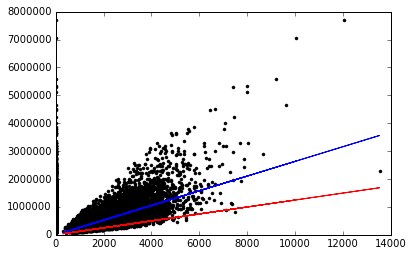

In [17]:
plt.plot(model1_feature_matrix,output,'k.',
         model1_feature_matrix,predict_output(model1_feature_matrix, model1_weights_0_penalty),'b-',
         model1_feature_matrix,predict_output(model1_feature_matrix, model1_weights_high_penalty),'r-');

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [18]:
rss_model1_initial_weights = np.square(predict_output(model1_test_feature_matrix, initial_weights_model1) - test_output).sum()
rss_model1_0_penalty = np.square(predict_output(model1_test_feature_matrix, model1_weights_0_penalty) - test_output).sum()
rss_model1_high_penalty = np.square(predict_output(model1_test_feature_matrix, model1_weights_high_penalty) - test_output).sum()

#### QUIZ QUESTIONS
- What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?




In [19]:
print("coefficient of sqft_living no regularisation:",round(model1_weights_0_penalty[1,0],1))
print("coefficient of sqft_living high regularisation:",round(model1_weights_high_penalty[1,0],1))

coefficient of sqft_living no regularisation: 263.0
coefficient of sqft_living high regularisation: 124.6


- Comparing the lines you fit with the with no regularization versus high regularization, which one is steeper?

**Model with no regularisation is steeper!**

- What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)?

In [20]:
print("rss_model1_initial_weights:",rss_model1_initial_weights)
print("rss_model1_0_penalty      :",rss_model1_0_penalty)
print("rss_model1_high_penalty   :",rss_model1_high_penalty)

rss_model1_initial_weights: 1.78427328614e+15
rss_model1_0_penalty      : 2.75723632154e+14
rss_model1_high_penalty   : 6.9464210149e+14


# Running a multiple regression with L2 penalty

Let us now consider a model with 2 features: `['sqft_living', 'sqft_living15']`.

First, create Numpy versions of your training and test data with these two features. 

In [21]:
model2_features = ["sqft_living", "sqft_living15"] # sqft_living15 is the average squarefeet for the nearest 15 neighbors. 
my_output = ["price"]
(model2_feature_matrix, output) = get_numpy_data(train_data, model2_features, my_output)
(model2_test_feature_matrix, test_output) = get_numpy_data(test_data, model2_features, my_output)

We need to re-inialize the weights, since we have one extra parameter. Let us also set the step size and maximum number of iterations.

In [22]:
initial_weights_model2 = np.array([0.0,0.0,0.0]).reshape(-1,1)
step_size = 1e-12
max_iterations = 1000

First, let's consider no regularization.  Set the `l2_penalty` to `0.0` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_0_penalty`

In [23]:
l2_penalty=0.0
model2_weights_0_penalty = ridge_regression_gradient_descent(model2_feature_matrix, output,
                                                             initial_weights_model2, step_size,
                                                             l2_penalty, max_iterations)

Next, let's consider high regularization.  Set the `l2_penalty` to `1e11` and run your ridge regression algorithm to learn the weights of your model.  Call your weights:

`multiple_weights_high_penalty`

In [24]:
l2_penalty=1e11
model2_weights_high_penalty = ridge_regression_gradient_descent(model2_feature_matrix, output,
                                                             initial_weights_model2, step_size,
                                                             l2_penalty, max_iterations)

Compute the RSS on the TEST data for the following three sets of weights:
1. The initial weights (all zeros)
2. The weights learned with no regularization
3. The weights learned with high regularization

Which weights perform best?

In [25]:
rss_model2_initial_weights = np.square(predict_output(model2_test_feature_matrix, initial_weights_model2) - test_output).sum()
rss_model2_0_penalty = np.square(predict_output(model2_test_feature_matrix, model2_weights_0_penalty) - test_output).sum()
rss_model2_high_penalty = np.square(predict_output(model2_test_feature_matrix, model2_weights_high_penalty) - test_output).sum()

Predict the house price for the 1st house in the test set using the no regularization and high regularization models. (Remember that python starts indexing from 0.) How far is the prediction from the actual price?  Which weights perform best for the 1st house?

In [26]:
house1_price_0_penalty = predict_output(model2_test_feature_matrix, model2_weights_0_penalty)[0,0]
house1_price_high_penalty = predict_output(model2_test_feature_matrix, model2_weights_high_penalty)[0,0]
print("Price of first house no regularisation  :",round(house1_price_0_penalty,2))
print("Price of first house high regularisation:",round(house1_price_high_penalty,2))
print("Real Price                              :",round(test_output[0,0],2))

Price of first house no regularisation  : 387465.48
Price of first house high regularisation: 270453.53
Real Price                              : 310000.0


#### QUIZ QUESTIONS
- What is the value of the coefficient for `sqft_living` that you learned with no regularization, rounded to 1 decimal place?  What about the one with high regularization?


In [27]:
print("coefficient of sqft_living no regularisation:",round(model2_weights_0_penalty[1,0],1))
print("coefficient of sqft_living high regularisation:",round(model2_weights_high_penalty[1,0],1))

coefficient of sqft_living no regularisation: 243.1
coefficient of sqft_living high regularisation: 91.5


- What are the RSS on the test data for each of the set of weights above (initial, no regularization, high regularization)? 


In [28]:
print("rss_model2_initial_weights:",rss_model2_initial_weights)
print("rss_model2_0_penalty      :",rss_model2_0_penalty)
print("rss_model2_high_penalty   :",rss_model2_high_penalty)

rss_model2_initial_weights: 1.78427328614e+15
rss_model2_0_penalty      : 2.74067615919e+14
rss_model2_high_penalty   : 5.00404800501e+14


- We make prediction for the first house in the test set using two sets of weights (no regularization vs high regularization). Which weights make better prediction <u>for that particular house</u>?

Better prediction is min(prediction error of each model)! So: 

In [29]:
print("House 1 error for no regularisation  :",np.square(house1_price_0_penalty - test_output[0,0]))
print("House 1 error for high regularisation:",np.square(house1_price_high_penalty - test_output[0,0]))

House 1 error for no regularisation  : 6000899980.93
House 1 error for high regularisation: 1563923264.0
